# 10-Q SEC Filing Sentiment and Similiarity Metrics Example Notebook

...

In [1]:
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import multiprocessing as mp
import matplotlib.pyplot as plt
from ast import literal_eval
from tqdm.notebook import tqdm
from finpie import historical_prices
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# set plot styles
plt.style.use('seaborn')
plt.rcParams['text.color'] = 'black'
plt.rcParams[ "figure.figsize"] = (20, 10)

# load custom classes
from classes.sec_class import SecData
from classes.wordcloud_class import wordCloud
from classes.text_processing_class import textPreProcess

sec = SecData()
wc = wordCloud()
tpp = textPreProcess()


### To do:
- add 10-Ks to fill the gap
- cleaning:
    - clean docs of 'Table of Contents'
    - clean docs of Management’s Discussion and Analysis of Financial Condition and Results of Operations 
    - clean docs of forward looking statement or other common texts
    - clean docs of table description such as: ''the following table shows'
    - clean docs of table footnotes '(1)'
    - clean other things and improve regex..

## Download 10-Q SEC Filings

In [2]:
cik_dict = { 'AAPL': '0000320193' } # 'XOM': '0000034088', 'TSLA': '0001318605', 'JNJ': '0000200406' }
ten_qs = {}
for ticker, cik in tqdm(cik_dict.items()):
    ten_qs[ticker] = sec.get_10qs( cik )

In [3]:
ticker_dict = {}
for ticker in cik_dict.keys():
    print(ticker)
    mdna = {}
    for file_date, doc in tqdm(ten_qs[ticker].items()):
        mdna[file_date] = sec.get_mdna(doc)
    df = pd.DataFrame(mdna, index = ['MDnA']).transpose()
    ticker_dict[ticker] = df
    #display(df.head())
# example
print(ticker, ' example')
display(df.head())
print(df.iloc[0].values[0][:1000])

AAPL



AAPL  example


,MDnA
2020-07-31,. Management’s Discussion and Analysis of Fina...
2020-05-01,.Management’s Discussion and Analysis of Finan...
2020-01-29,.Management’s Discussion and Analysis of Finan...
2019-07-31,.Management’s Discussion and Analysis of Finan...
2019-05-01,.Management’s Discussion and Analysis of Finan...


. Management’s Discussion and Analysis of Financial Condition and Results of OperationsThis section and other parts of this Quarterly Report on Form 10-Q (“Form 10-Q”) contain forward-looking statements, within the meaning of the Private Securities Litigation Reform Act of 1995, that involve risks and uncertainties. Forward-looking statements provide current expectations of future events based on certain assumptions and include any statement that does not directly relate to any historical or current fact. For example, statements in this Form 10-Q regarding the potential future impact of the COVID-19 pandemic on the Company’s business and results of operations are forward-looking statements. Forward-looking statements can also be identified by words such as “future,” “anticipates,” “believes,” “estimates,” “expects,” “intends,” “plans,” “predicts,” “will,” “would,” “could,” “can,” “may,” and similar terms. Forward-looking statements are not guarantees of future performance and the Compa

In [4]:
# Illustrative Example:
ticker = 'AAPL'
df = ticker_dict[ticker]

## Word Clouds

In [5]:
# create classes
wc = wordCloud()
tpp = textPreProcess()
tpp.textColumn = 'MDnA'

# load stopwords
stopword_files = glob.glob('./stopwords/*.txt')
stopwords = nltk_stopwords.words('english')
for file in stopword_files:
    stopwords += list(pd.read_csv(file).iloc[:,0])
stopwords = [ word.lower() for word in stopwords if type(word) == type("") ]
tpp.stopwords = stopwords




/Users/PeterlaCour/Documents/Research.nosync/SEC/sec_github/classes/wordcloud_class.py:70: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax.append( fig.add_subplot(rows, columns, count+1 ) )


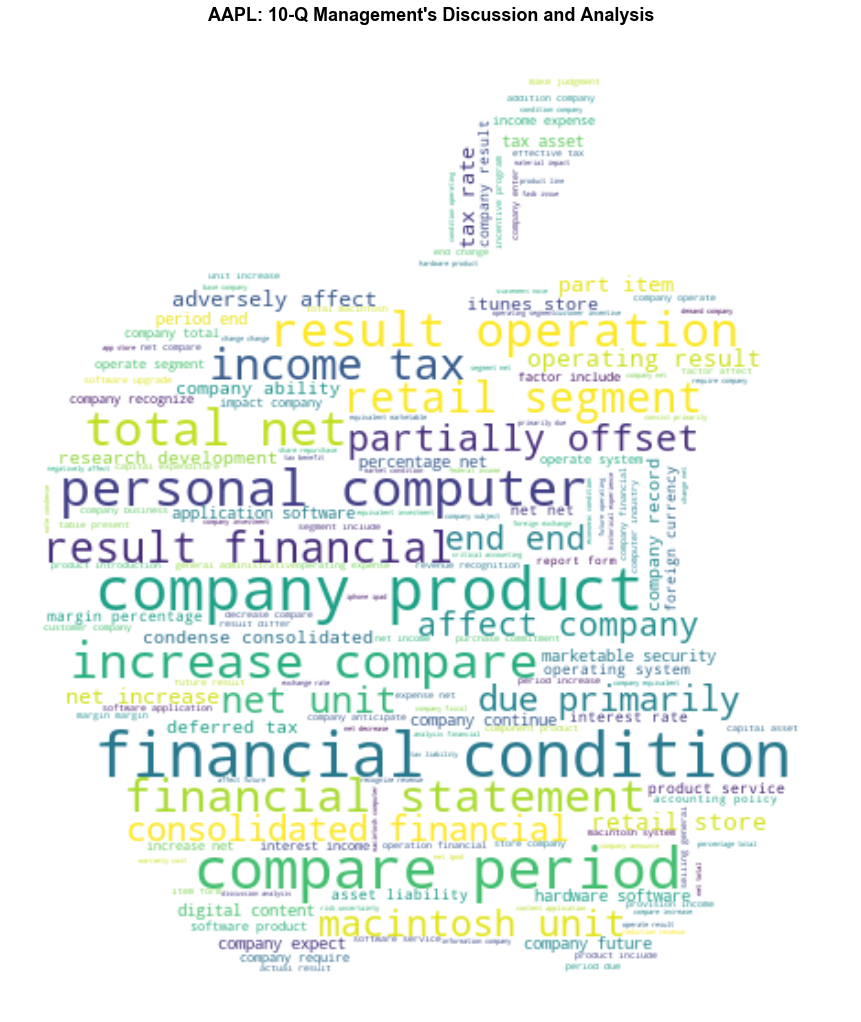

In [7]:
# split dataframe
dflist = np.array_split(df,  mp.cpu_count() )
with mp.Pool(mp.cpu_count()) as pool:
    dfs = list(tqdm(pool.imap( tpp.lemmatize,  [ d for d in dflist ] ), total = len(dflist) ))
df = pd.concat( dfs )

wordCloudDict = { f'{ticker}: 10-Q Management\'s Discussion and Analysis': df.lemmatised_text }
wc.create_word_cloud( wordCloudDict,  masks = f'./logos/{ticker.lower()}_logo', title = "company", columns = 1, rows = 1 )


...

## Lexica based sentiment example using Loughran McDonald Dictionary

In [8]:
# load dictionary
lmcd_dictionary = pd.read_csv('LoughranMcDonald_MasterDictionary_2018.csv')
columns = ['Word', 'Negative', 'Positive', 'Uncertainty', 'Litigious', 'Constraining', 'Superfluous', 'Interesting']
lmcd_dictionary = lmcd_dictionary[columns]
lmcd_dictionary.dropna(subset = ['Word'], inplace = True, axis = 0)
lmcd_dictionary.reset_index(drop = True, inplace = True)

def lmcd_sentiment(df_idx):
    df_idx = df_idx.copy()
    text = df_idx.text.values[0] #' '.join( literal_eval( df_idx.lemmatised_text.values[0] ) )
    for i, word in enumerate(lmcd_dictionary.Word):
        if word in text.upper():
            df_idx[columns[1:]] += lmcd_dictionary.loc[i, columns[1:]].values
    return pd.DataFrame(df_idx)

In [9]:
for col in columns[1:]:
    df[col] = 0
# concatenated texts...
df['text'] = [ ' '.join( literal_eval( txt ) ) for txt in df.lemmatised_text ]

# calculate lexica based sentiment
with mp.Pool(mp.cpu_count()) as pool:
    dfs = list(tqdm(pool.imap( lmcd_sentiment, [d for d in np.array_split(df, len(df))] ), total = len(df) ))
df = pd.concat( dfs )
df.index = pd.to_datetime(df.index)
df.sort_index(inplace = True)
display(df.head())

,MDnA,lemmatised_text,Negative,Positive,Uncertainty,Litigious,Constraining,Superfluous,Interesting,text
1994-01-26,. Management's Discussion and Analysis of Fin...,"['management', 'discussion', 'analysis', 'fina...",56252,46207,26117,18085,14067,0,6027,management discussion analysis financial condi...
1994-08-12,. Management's Discussion and Analysis of Fin...,"['management', 'discussion', 'analysis', 'fina...",88396,48216,36164,20094,18085,0,6027,management discussion analysis financial condi...
1995-02-09,. Management's Discussion and Analysis of Fin...,"['management', 'discussion', 'analysis', 'fina...",86387,60270,36162,30139,18085,0,4018,management discussion analysis financial condi...
1995-05-15,. Management's Discussion and Analysis of Fin...,"['management', 'discussion', 'analysis', 'fina...",94423,58261,38171,30139,18085,0,4018,management discussion analysis financial condi...
1995-08-11,. Management's Discussion and Analysis of Fin...,"['management', 'discussion', 'analysis', 'fina...",90405,62279,40180,30139,20094,0,4018,management discussion analysis financial condi...


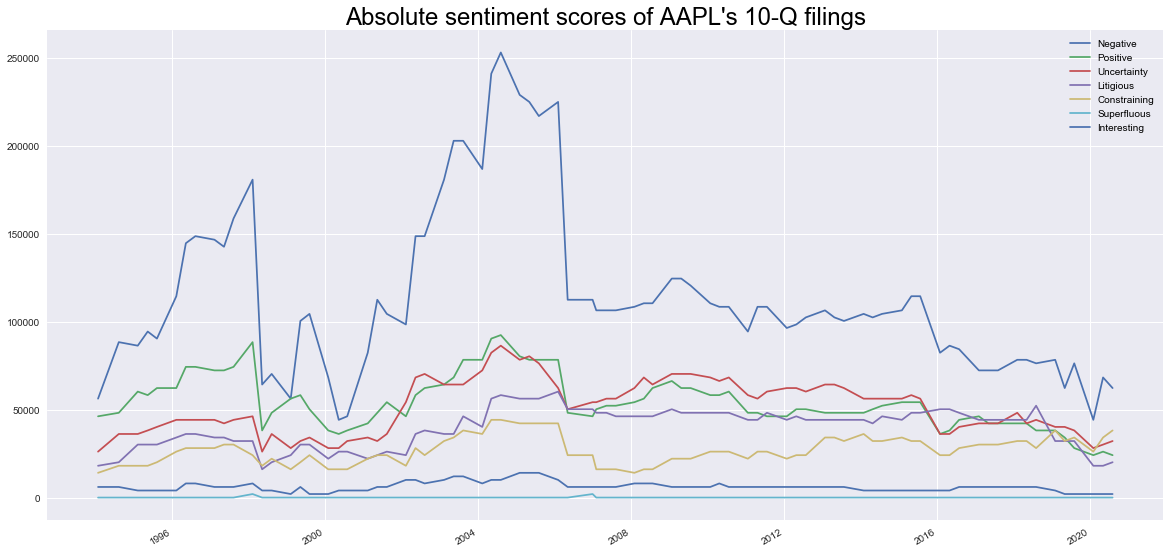

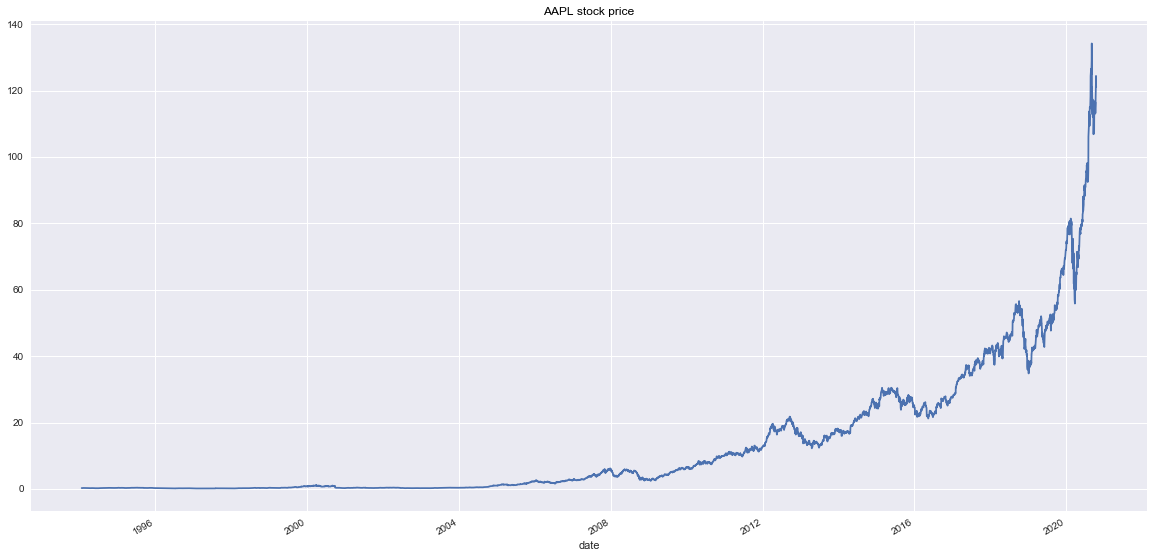

In [10]:
# plot absolute 
df.index = pd.to_datetime(df.index)
df.sort_index(inplace = True)
df[columns[1:]].plot()
plt.title(f'Absolute sentiment scores of {ticker}\'s 10-Q filings', fontsize = 24)
plt.show()

# Get price data
prices = historical_prices(ticker)
prices['adj_close'][df.index[0]:].plot()
plt.title(f'{ticker} stock price')
plt.show()

In [20]:
df

,MDnA,lemmatised_text,Negative,Positive,Uncertainty,Litigious,Constraining,Superfluous,Interesting,text,quarter_returns,doc_length
1994-01-26,. Management's Discussion and Analysis of Fin...,"['management', 'discussion', 'analysis', 'fina...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,management discussion analysis financial condi...,0.045145,17564
1994-08-12,. Management's Discussion and Analysis of Fin...,"['management', 'discussion', 'analysis', 'fina...",0.080765,-0.282338,-0.047665,-0.235840,-0.115794,NaN,-0.312241,management discussion analysis financial condi...,0.263522,25538
1995-02-09,. Management's Discussion and Analysis of Fin...,"['management', 'discussion', 'analysis', 'fina...",-0.014936,0.259966,0.007917,0.511859,0.007973,NaN,-0.328018,management discussion analysis financial condi...,0.002749,25336
1995-05-15,. Management's Discussion and Analysis of Fin...,"['management', 'discussion', 'analysis', 'fina...",-0.033814,-0.145507,-0.066933,-0.116042,-0.116042,NaN,-0.116042,management discussion analysis financial condi...,-0.010162,28662
1995-08-11,. Management's Discussion and Analysis of Fin...,"['management', 'discussion', 'analysis', 'fina...",-0.065347,0.043517,0.027571,-0.023807,0.084635,NaN,-0.023807,management discussion analysis financial condi...,-0.337220,29361
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-05-01,.Management’s Discussion and Analysis of Finan...,"['discussion', 'analysis', 'financial', 'condi...",-0.108699,0.003282,0.121315,0.121315,-0.055874,NaN,-0.439343,discussion analysis financial condition result...,0.015867,22759
2019-07-31,.Management’s Discussion and Analysis of Finan...,"['discussion', 'analysis', 'financial', 'condi...",0.129433,-0.241217,-0.124689,-0.078620,-0.020866,NaN,-0.078620,discussion analysis financial condition result...,0.532810,24701
2020-01-29,.Management’s Discussion and Analysis of Finan...,"['discussion', 'analysis', 'financial', 'condi...",-0.092430,0.343675,0.155089,-0.118171,0.198488,NaN,0.567621,discussion analysis financial condition result...,-0.106629,15757
2020-05-01,.Management’s Discussion and Analysis of Finan...,"['discussion', 'analysis', 'financial', 'condi...",0.197822,-0.160350,-0.169577,-0.224939,0.013601,NaN,-0.224939,discussion analysis financial condition result...,0.474351,20330


In [ ]:
# add quarter on quarter returns to dataframe
# should really start at next days opening price but keeping this for simplicity for now
df['quarter_returns'] = prices['adj_close'].loc[df.index].pct_change().shift(-1)

# rescale sentiment based on doc length -> "average sentiments"
df['doc_length'] = [ len(d) for d in df.lemmatised_text ]
for col in columns[1:]:
    df[col] = df[col] / df['doc_length']

# Show standardised sentiment
df.index = pd.to_datetime(df.index)
df.sort_index(inplace = True)
df[columns[1:]].plot()
plt.title(f'Sentiment scores of {ticker}\'s 10-Q filings', fontsize = 24)
plt.show()

# correlation between returns and average metrics
print('Correlation between returns and standardised metrics:')
display(df[columns[1:] + ['quarter_returns']].corr())
#sns.heatmap(df[columns[1:] + ['quarter_returns']].corr(), cmap = 'Blues')
#plt.show()

,Negative,Positive,Uncertainty,Litigious,Constraining,Superfluous,Interesting,quarter_returns
Negative,1.000000,0.224751,0.232990,-0.025736,0.422873,NaN,0.255966,-0.168920
Positive,0.224751,1.000000,0.622460,0.475404,0.503197,NaN,0.316076,-0.000452
Uncertainty,0.232990,0.622460,1.000000,0.516805,0.550661,NaN,0.416318,0.001407
Litigious,-0.025736,0.475404,0.516805,1.000000,0.362877,NaN,0.320827,0.076563
Constraining,0.422873,0.503197,0.550661,0.362877,1.000000,NaN,0.198583,-0.122630
Superfluous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Interesting,0.255966,0.316076,0.416318,0.320827,0.198583,NaN,1.000000,-0.036683
quarter_returns,-0.168920,-0.000452,0.001407,0.076563,-0.122630,NaN,-0.036683,1.000000


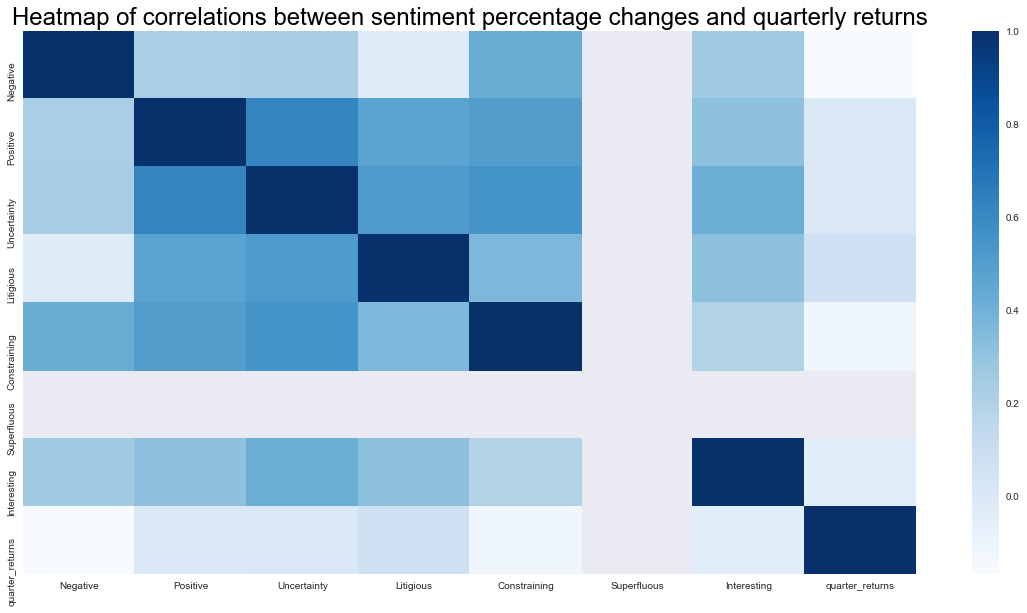

In [12]:
# calculating % change of metric from report to report
# superfluous has many zero values, still need to deal with this issue in percentage calculation,
# and for other companies other metrics might have missing values
df[columns[1:]] = df[columns[1:]].pct_change()

# correlation between percentage changes and returns
display(df[columns[1:] + ['quarter_returns']].corr())
plt.title('Heatmap of correlations between sentiment percentage changes and quarterly returns', fontsize = 24)
sns.heatmap(df[columns[1:] + ['quarter_returns']].corr(), cmap = 'Blues' )
plt.show()
df.to_csv(f'{ticker}.csv')

## Similarity Metrics

### Cosine Similarity Scores of 10-Q's

In [13]:
# cosine similarity with tfidf or word2vec
tfidf = TfidfVectorizer()
tfidf_df = tfidf.fit_transform(df.text).toarray()
rows = []
for j in range(len(tfidf_df)):
    columns = []
    for i in range(len(tfidf_df)):
        columns.append( cosine_similarity(tfidf_df[j].reshape(1, -1), tfidf_df[i].reshape(1, -1))[0][0] )
    rows.append(columns)


,1994-01-26,1994-08-12,1995-02-09,1995-05-15,1995-08-11,1996-02-12,1996-05-13,1996-08-12,1997-02-10,1997-05-12,...,2017-08-02,2018-02-02,2018-05-02,2018-08-01,2019-01-30,2019-05-01,2019-07-31,2020-01-29,2020-05-01,2020-07-31
1994-01-26,1.000000,0.878369,0.858761,0.845633,0.848178,0.851594,0.836922,0.829260,0.810267,0.816604,...,0.595510,0.589953,0.592078,0.586235,0.628450,0.600197,0.601948,0.569397,0.544281,0.558448
1994-08-12,0.878369,1.000000,0.929547,0.918915,0.913510,0.918111,0.884871,0.881480,0.869446,0.861637,...,0.585610,0.583967,0.585925,0.582726,0.626036,0.589286,0.594640,0.553068,0.525156,0.541229
1995-02-09,0.858761,0.929547,1.000000,0.982277,0.974758,0.944270,0.909295,0.907085,0.882686,0.880713,...,0.589546,0.583277,0.584297,0.578835,0.631124,0.592735,0.596862,0.561720,0.532077,0.549317
1995-05-15,0.845633,0.918915,0.982277,1.000000,0.986668,0.941737,0.908345,0.906681,0.881417,0.882195,...,0.603517,0.590433,0.594479,0.589204,0.641515,0.610961,0.615111,0.579453,0.547014,0.569355
1995-08-11,0.848178,0.913510,0.974758,0.986668,1.000000,0.951487,0.917808,0.916056,0.888504,0.888525,...,0.606029,0.596179,0.599901,0.594410,0.644509,0.612213,0.616117,0.581286,0.546911,0.569013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-05-01,0.600197,0.589286,0.592735,0.610961,0.612213,0.609639,0.627548,0.635700,0.621395,0.645254,...,0.898254,0.870324,0.881505,0.877668,0.953209,1.000000,0.976697,0.936386,0.855574,0.893976
2019-07-31,0.601948,0.594640,0.596862,0.615111,0.616117,0.617252,0.635382,0.641832,0.627287,0.648667,...,0.882871,0.850796,0.860208,0.856758,0.973040,0.976697,1.000000,0.939919,0.856425,0.895875
2020-01-29,0.569397,0.553068,0.561720,0.579453,0.581286,0.573749,0.591798,0.600469,0.584356,0.605523,...,0.817592,0.799846,0.802474,0.800217,0.911849,0.936386,0.939919,1.000000,0.877684,0.915625
2020-05-01,0.544281,0.525156,0.532077,0.547014,0.546911,0.542506,0.556496,0.563103,0.550994,0.573485,...,0.754191,0.715706,0.732941,0.732389,0.823599,0.855574,0.856425,0.877684,1.000000,0.918039


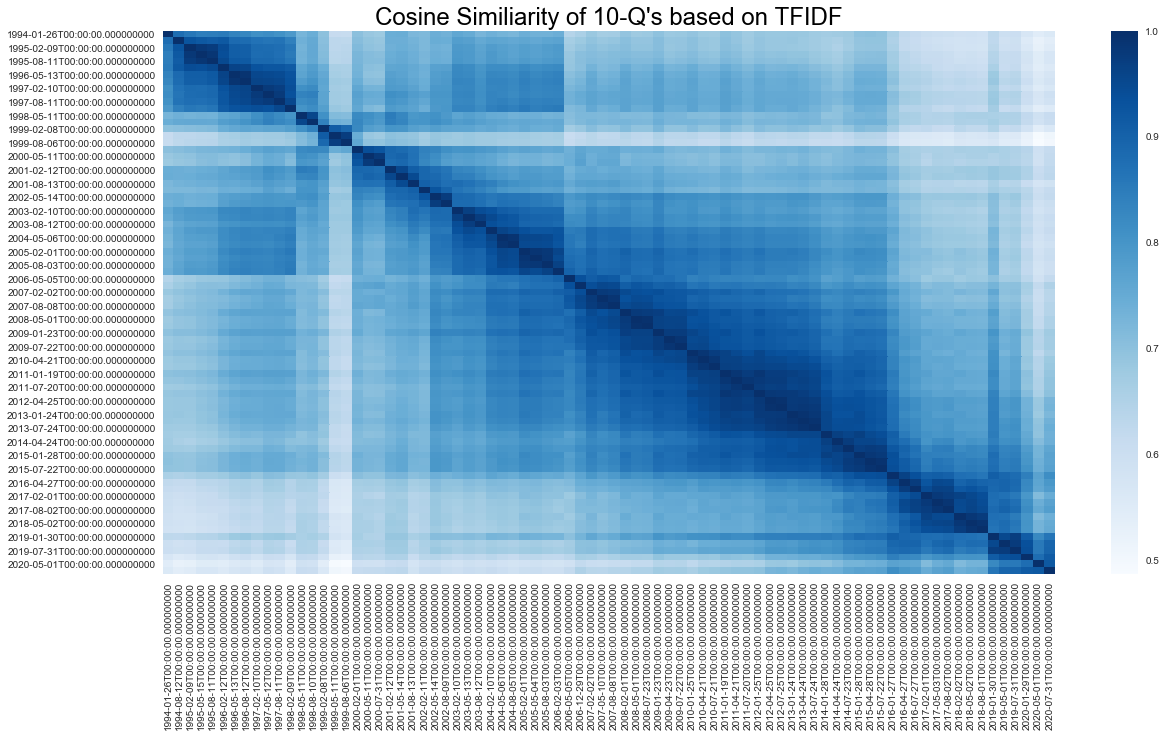

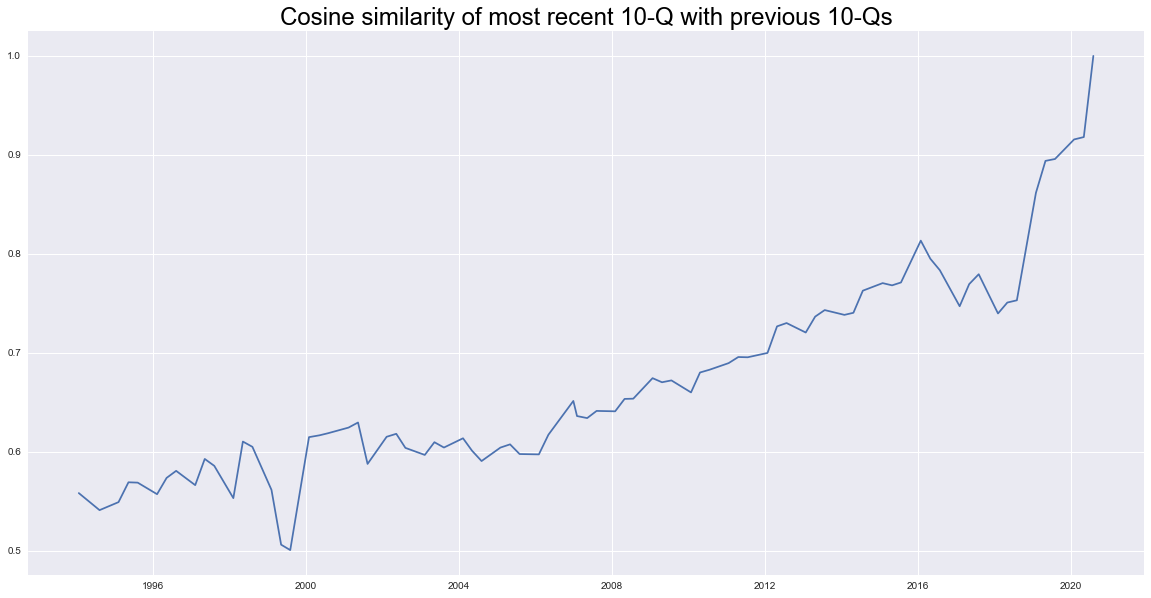

In [14]:
cosine_similiarity = pd.DataFrame(rows, columns = df.index, index = df.index )
display(cosine_similiarity)

# similiarity heatmap plot
sns.heatmap(cosine_similiarity, cmap = 'Blues')
plt.title('Cosine Similiarity of 10-Q\'s based on TFIDF', fontsize = 24 )
plt.show()

# plot of similiarity of previous reports to most recent report
plt.plot(cosine_similiarity.iloc[:,-1])
plt.title('Cosine similarity of most recent 10-Q with previous 10-Qs', fontsize = 24 )
plt.show()

### Containment N-gram scores

In [15]:
# containment function
def calculate_containment(df1, df2, ngram_size):
    text1 = df1.text
    text2 = df2.text
    counts = CountVectorizer(analyzer='word', ngram_range=(ngram_size, ngram_size))
    ngrams = counts.fit_transform([text1, text2])
    
    ngram_array = ngrams.toarray()
    intersect = np.amin(ngram_array, axis=0)
    common_ngrams = sum(intersect)
    
    len_ngram_a = sum(ngram_array[0])
    
    containment_score = 1.0 * common_ngrams / len_ngram_a
    
    return containment_score

,1994-01-26,1994-08-12,1995-02-09,1995-05-15,1995-08-11,1996-02-12,1996-05-13,1996-08-12,1997-02-10,1997-05-12,...,2017-08-02,2018-02-02,2018-05-02,2018-08-01,2019-01-30,2019-05-01,2019-07-31,2020-01-29,2020-05-01,2020-07-31
1994-01-26,1.000000,0.460490,0.384475,0.327031,0.308386,0.246951,0.187904,0.181636,0.161316,0.144627,...,0.071914,0.066807,0.066269,0.063633,0.078234,0.082889,0.080341,0.082163,0.082155,0.078791
1994-08-12,0.669307,1.000000,0.629680,0.552293,0.520768,0.415312,0.327070,0.317506,0.276351,0.245652,...,0.083721,0.075901,0.076209,0.074451,0.090909,0.090645,0.089318,0.088483,0.091948,0.089045
1995-02-09,0.555776,0.626249,1.000000,0.798874,0.728056,0.531504,0.416031,0.402460,0.347780,0.310936,...,0.086941,0.080448,0.080186,0.076360,0.094406,0.095977,0.094255,0.099017,0.100109,0.097679
1995-05-15,0.536634,0.623524,0.906849,1.000000,0.860502,0.582656,0.458309,0.443364,0.389781,0.348582,...,0.096601,0.087093,0.089795,0.085587,0.099213,0.106156,0.104578,0.104635,0.106638,0.101997
1995-08-11,0.519472,0.603542,0.848402,0.883347,1.000000,0.632114,0.487962,0.471968,0.410380,0.365737,...,0.094454,0.085345,0.087806,0.083042,0.100524,0.105671,0.103680,0.103933,0.105005,0.100917
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-05-01,0.112871,0.084923,0.090411,0.088093,0.085423,0.069783,0.073400,0.073227,0.071429,0.069812,...,0.488372,0.487583,0.493704,0.482024,0.749126,1.000000,0.845601,0.875702,0.722524,0.675661
2019-07-31,0.118152,0.090372,0.095890,0.093725,0.090517,0.073848,0.076923,0.074943,0.072499,0.070765,...,0.499463,0.497726,0.500000,0.487432,0.840909,0.913233,1.000000,0.889747,0.726333,0.692391
2020-01-29,0.077228,0.057221,0.064384,0.059936,0.057994,0.045393,0.049912,0.050343,0.047084,0.045509,...,0.350626,0.357118,0.344930,0.327076,0.534091,0.604460,0.568671,1.000000,0.692601,0.658392
2020-05-01,0.099670,0.076748,0.084018,0.078842,0.075627,0.061314,0.066647,0.065789,0.063938,0.062902,...,0.373524,0.353970,0.363817,0.348711,0.527098,0.643723,0.599192,0.893961,1.000000,0.826767


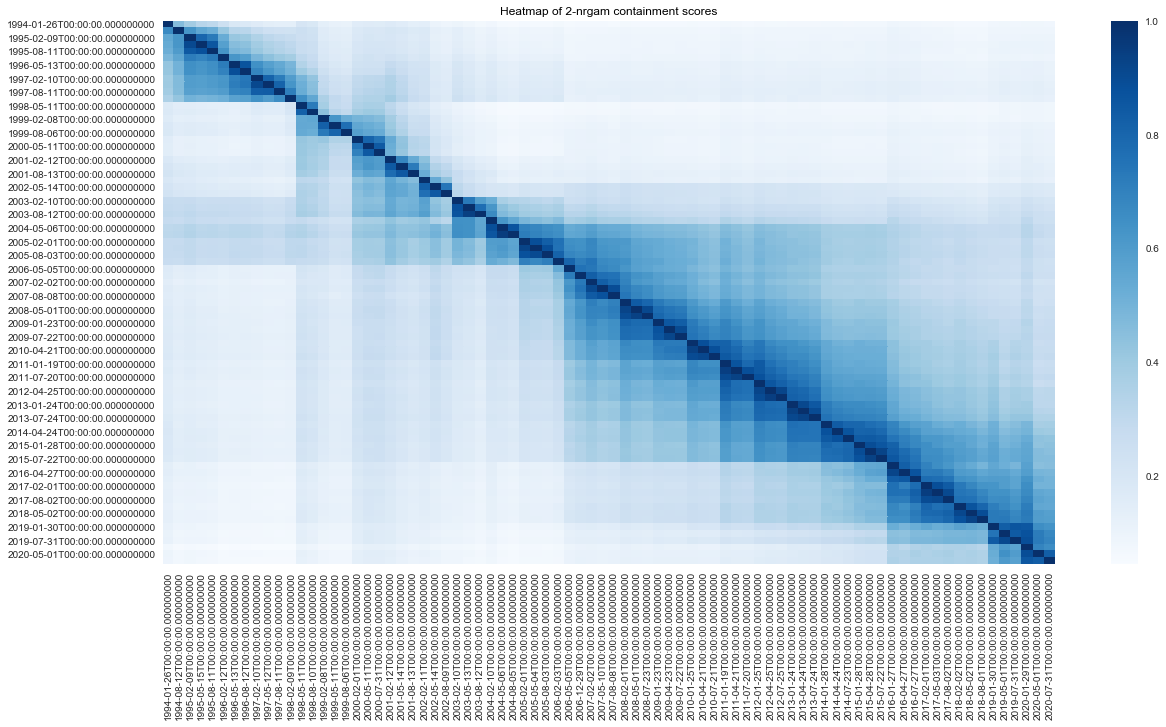

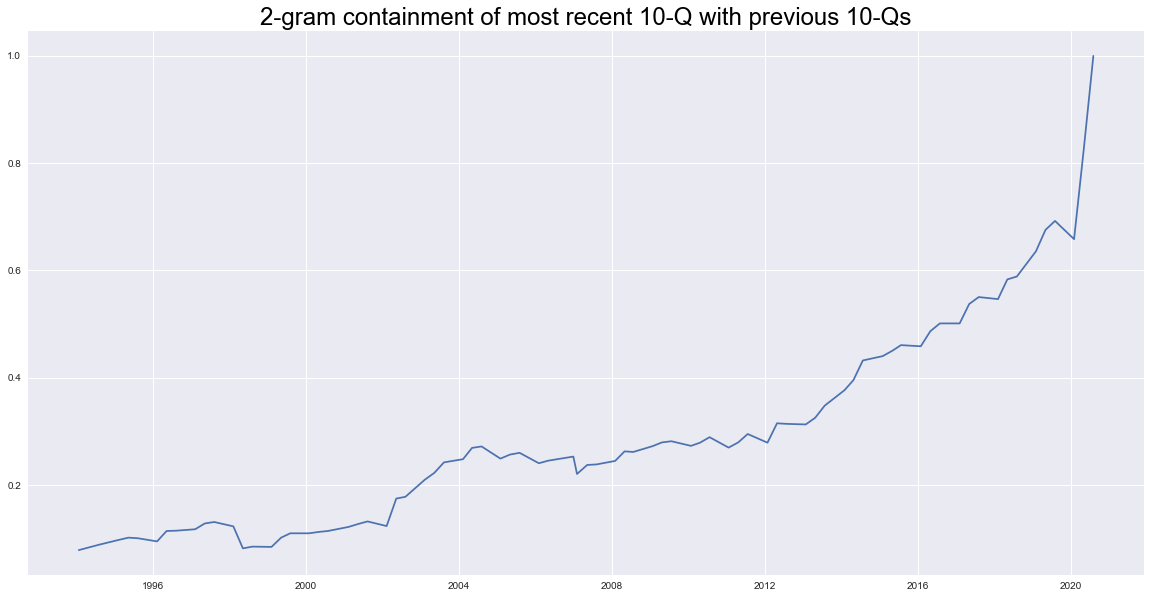

In [17]:
# 2-ngram containment
ngram = 2
rows = []
for j in range(len(df)):
    columns = []
    for i in range(len(df)):
        columns.append( calculate_containment( df.iloc[i], df.iloc[j], ngram ) )
    rows.append(columns)
containment_df = pd.DataFrame(rows, index = pd.to_datetime(df.index), columns = df.index )

# containment df
display(containment_df)

# containment heatmap
plt.title('Heatmap of 2-nrgam containment scores')
sns.heatmap(containment_df, cmap = 'Blues')
plt.show()


# plot of containment of previous reports to most recent report
plt.plot(containment_df.iloc[:,-1])
plt.title('2-gram containment of most recent 10-Q with previous 10-Qs', fontsize = 24 )
plt.show()